In [5]:
# %% [markdown]
# # Random Forest Regression for Train Delay Prediction with 'info' Encoding

# %%
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv('DBtrainrides_final_result.csv')

In [11]:
df.head()

,ID_Base,ID_Timestamp,stop_number,IBNR,long,lat,arrival_plan,departure_plan,arrival_delay_m,transformed_info_message,prev_arrival_delay_m,prev_departure_delay_m,weighted_avg_prev_delay,max_station_number,station_progress
0,-1001326572688500578,2407082041,2,8011118.0,13.375988,52.509379,2024-07-08 20:44:00,2024-07-08 20:45:00,0.0,No message,0.0,0.0,0.000000,7,0.285714
1,-1001326572688500578,2407082041,3,8011160.0,9.095851,48.849792,NaN,NaN,NaN,No message,0.0,0.0,0.000000,7,0.428571
2,-1001326572688500578,2407082041,4,8011167.0,13.299437,52.530276,2024-07-08 20:55:00,2024-07-08 20:56:00,0.0,No message,0.0,0.0,0.000000,7,0.571429
3,-1001326572688500578,2407082041,5,8010404.0,13.196898,52.534648,2024-07-08 21:00:00,2024-07-08 21:03:00,2.0,No message,0.0,0.0,0.000000,7,0.714286
4,-1001326572688500578,2407082041,6,8080040.0,13.128917,52.549396,2024-07-08 21:06:00,2024-07-08 21:07:00,1.0,No message,2.0,0.0,0.666667,7,0.857143


Data Preview:
               ID_Base  ID_Timestamp  stop_number       IBNR       long  \
0 -1001326572688500578    2407082041            2  8011118.0  13.375988   
1 -1001326572688500578    2407082041            3  8011160.0   9.095851   
2 -1001326572688500578    2407082041            4  8011167.0  13.299437   
3 -1001326572688500578    2407082041            5  8010404.0  13.196898   
4 -1001326572688500578    2407082041            6  8080040.0  13.128917   

         lat         arrival_plan       departure_plan  arrival_delay_m  \
0  52.509379  2024-07-08 20:44:00  2024-07-08 20:45:00              0.0   
1  48.849792                  NaN                  NaN              NaN   
2  52.530276  2024-07-08 20:55:00  2024-07-08 20:56:00              0.0   
3  52.534648  2024-07-08 21:00:00  2024-07-08 21:03:00              2.0   
4  52.549396  2024-07-08 21:06:00  2024-07-08 21:07:00              1.0   

  transformed_info_message  prev_arrival_delay_m  prev_departure_delay_m  \
0       

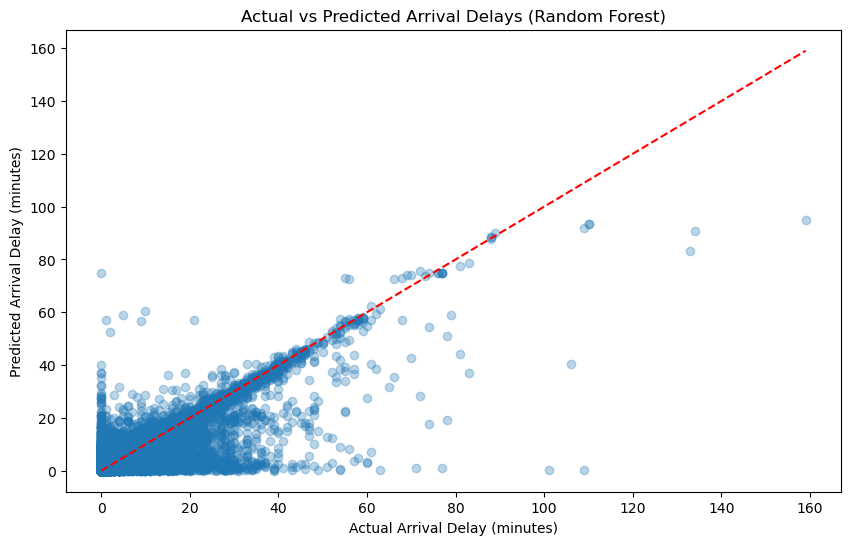


Top 15 Important Features:
                    Feature  Importance
5    prev_departure_delay_m    0.735078
6   weighted_avg_prev_delay    0.158995
10      arrival_plan_minute    0.026470
4      prev_arrival_delay_m    0.020086
3                       lat    0.012815
2                      long    0.011611
1                      IBNR    0.009110
8          station_progress    0.005032
7        max_station_number    0.004871
14    departure_plan_minute    0.004661
0               stop_number    0.004490
9         arrival_plan_hour    0.001922
13      departure_plan_hour    0.001881
17             info_encoded    0.001155
12         arrival_plan_day    0.000476


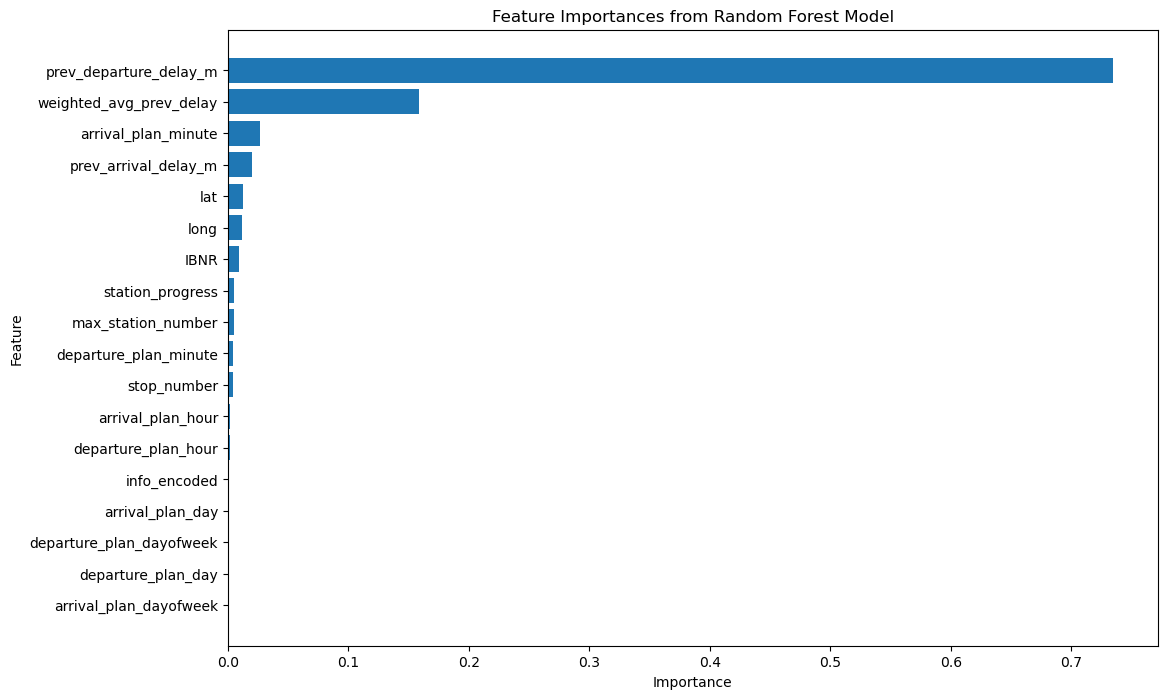

In [18]:

# %%
# List of features to include
feature_columns = [
    'stop_number',
    'IBNR',
    'long',
    'lat',
    'arrival_plan',
    'departure_plan',
    'prev_arrival_delay_m',
    'prev_departure_delay_m',
    'weighted_avg_prev_delay',
    'max_station_number',
    'station_progress',
    'transformed_info_message'  # Include for encoding
]

# Target variable
target_column = 'arrival_delay_m'  # Predicting arrival delay in minutes

# Create a new DataFrame with the selected features and target
data = df[feature_columns + [target_column]].copy()

# Display data types
print("\nData Types:")
print(data.dtypes)

# %% [markdown]
# ## Data Preprocessing

# %%
# Handle missing values
# Drop rows with missing target values
data = data.dropna(subset=[target_column])

# Convert numerical features to numeric data types and handle missing values
numerical_features = [
    'stop_number',
    'long',
    'lat',
    'prev_arrival_delay_m',
    'prev_departure_delay_m',
    'weighted_avg_prev_delay',
    'max_station_number',
    'station_progress'
]

# Convert to numeric and handle missing values
data[numerical_features] = data[numerical_features].apply(pd.to_numeric, errors='coerce')
data[numerical_features] = data[numerical_features].fillna(data[numerical_features].median())

# Convert categorical features to string type
categorical_features = ['IBNR']

for col in categorical_features:
    data[col] = data[col].astype(str)

# %% [markdown]
# ### Process Datetime Features

# %%
def extract_datetime_features(df, datetime_column):
    df[datetime_column] = pd.to_datetime(df[datetime_column], errors='coerce')
    df[datetime_column + '_hour'] = df[datetime_column].dt.hour
    df[datetime_column + '_minute'] = df[datetime_column].dt.minute
    df[datetime_column + '_dayofweek'] = df[datetime_column].dt.dayofweek
    df[datetime_column + '_day'] = df[datetime_column].dt.day
    # Drop the original datetime column
    df.drop(columns=[datetime_column], inplace=True)
    return df

data = extract_datetime_features(data, 'arrival_plan')
data = extract_datetime_features(data, 'departure_plan')

# Update numerical features list with new datetime features
datetime_features = [
    'arrival_plan_hour',
    'arrival_plan_minute',
    'arrival_plan_dayofweek',
    'arrival_plan_day',
    'departure_plan_hour',
    'departure_plan_minute',
    'departure_plan_dayofweek',
    'departure_plan_day'
]

numerical_features.extend(datetime_features)

# %% [markdown]
# ## Split Data into Training and Testing Sets

# %%
# Define X and y
X = data.drop(columns=[target_column])
y = data[target_column]

# Split the data (Ensure 'transformed_info_message' is included in X)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("\nTraining Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

# %% [markdown]
# ### Encode 'transformed_info_message' After Splitting (Preventing Data Leakage)

# %%
# Merge X_train and y_train back into a DataFrame for processing
train_data = X_train.copy()
train_data[target_column] = y_train

# Similarly for the test set
test_data = X_test.copy()
test_data[target_column] = y_test

# Compute Mean Delay for Each 'transformed_info_message' in the Training Set
mean_delay_by_info = train_data.groupby('transformed_info_message')[target_column].mean().reset_index()
mean_delay_by_info.columns = ['transformed_info_message', 'info_mean_delay']

# Rank 'transformed_info_message' Based on Mean Delay
mean_delay_by_info_sorted = mean_delay_by_info.sort_values('info_mean_delay')
mean_delay_by_info_sorted['info_rank'] = range(1, len(mean_delay_by_info_sorted) + 1)

print("\n'transformed_info_message' ranked by mean delay:")
print(mean_delay_by_info_sorted[['transformed_info_message', 'info_mean_delay', 'info_rank']])

# Create a mapping from 'transformed_info_message' to rank
info_rank_mapping = mean_delay_by_info_sorted.set_index('transformed_info_message')['info_rank'].to_dict()

# Handle unknown 'transformed_info_message' in the test set
default_rank = mean_delay_by_info_sorted['info_rank'].mean()

# Map 'transformed_info_message' to ranks in training and testing sets
def map_info_to_rank(info_value):
    return info_rank_mapping.get(info_value, default_rank)

train_data['info_encoded'] = train_data['transformed_info_message'].apply(map_info_to_rank)
test_data['info_encoded'] = test_data['transformed_info_message'].apply(map_info_to_rank)

# Drop the original 'transformed_info_message' column
train_data.drop(columns=['transformed_info_message'], inplace=True)
test_data.drop(columns=['transformed_info_message'], inplace=True)

# Update numerical features list to include 'info_encoded'
numerical_features.append('info_encoded')

# %% [markdown]
# ### Encode Categorical Variables

# %%
from sklearn.preprocessing import OrdinalEncoder

# Initialize OrdinalEncoder with handling for unknown labels
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Fit the encoder on the training data
train_data[categorical_features] = ordinal_encoder.fit_transform(train_data[categorical_features])

# Transform the test data
test_data[categorical_features] = ordinal_encoder.transform(test_data[categorical_features])

# Convert encoded values to integers
train_data[categorical_features] = train_data[categorical_features].astype(int)
test_data[categorical_features] = test_data[categorical_features].astype(int)

# Update numerical features list to include encoded categorical features
numerical_features.extend(categorical_features)

# %% [markdown]
# ## Normalize Numerical Features

# %%
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on training data and transform both training and testing data
X_train_scaled = train_data.copy()
X_test_scaled = test_data.copy()

X_train_scaled[numerical_features] = scaler.fit_transform(train_data[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(test_data[numerical_features])

# Separate features and target variable
X_train_final = X_train_scaled.drop(columns=[target_column])
y_train_final = X_train_scaled[target_column]

X_test_final = X_test_scaled.drop(columns=[target_column])
y_test_final = X_test_scaled[target_column]

# %% [markdown]
# ## Train the Ensemble Model (Random Forest Regressor)

# %%
# Initialize the Random Forest Regressor with hyperparameters
ensemble_model = RandomForestRegressor(
    n_estimators=100,       # Number of trees
    max_depth=15,           # Maximum depth of the tree
    min_samples_split=50,   # Minimum number of samples required to split an internal node
    random_state=42,
    n_jobs=-1               # Use all available cores
)

# Train the model on the training set
ensemble_model.fit(X_train_final, y_train_final)

# %% [markdown]
# ## Make Predictions and Evaluate the Model

# %%
# Make predictions on the test set
y_pred = ensemble_model.predict(X_test_final)

# Evaluate the model
mse = mean_squared_error(y_test_final, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_final, y_pred)
r2 = r2_score(y_test_final, y_pred)

print("\nRandom Forest Model Performance on Test Set:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2): {r2:.2f}")

# %% [markdown]
# ### Plot Predicted vs Actual Values

# %%
plt.figure(figsize=(10, 6))
plt.scatter(y_test_final, y_pred, alpha=0.3)
plt.xlabel('Actual Arrival Delay (minutes)')
plt.ylabel('Predicted Arrival Delay (minutes)')
plt.title('Actual vs Predicted Arrival Delays (Random Forest)')
plt.plot([y_test_final.min(), y_test_final.max()], [y_test_final.min(), y_test_final.max()], 'r--')
plt.show()

# %% [markdown]
# ## Feature Importance

# %%
# Get feature importances from the model
feature_importances = ensemble_model.feature_importances_
feature_names = X_train_final.columns

# Create a DataFrame for visualization
fi_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
fi_df = fi_df.sort_values('Importance', ascending=False)

# Display the top 15 features
print("\nTop 15 Important Features:")
print(fi_df.head(15))

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(fi_df['Feature'], fi_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest Model')
plt.gca().invert_yaxis()
plt.show()
